In [164]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [165]:
df = pd.read_csv("../inputs/spam_data.csv",encoding='ISO-8859-1')

In [166]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [167]:
df.shape

(5572, 5)

In [168]:
df = df[['v1','v2']]

In [169]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [170]:
df['v1'].value_counts()

ham     4825
spam     747
Name: v1, dtype: int64

In [171]:
df.isna().sum()

v1    0
v2    0
dtype: int64

In [172]:
df['v1'] = df['v1'].apply(lambda x: 1 if x=='spam' else 0)

<AxesSubplot:>

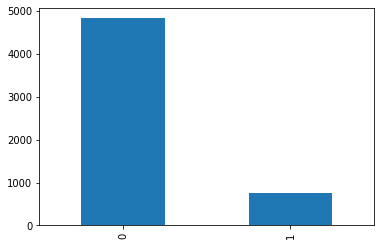

In [173]:
df['v1'].value_counts().plot(kind='bar')

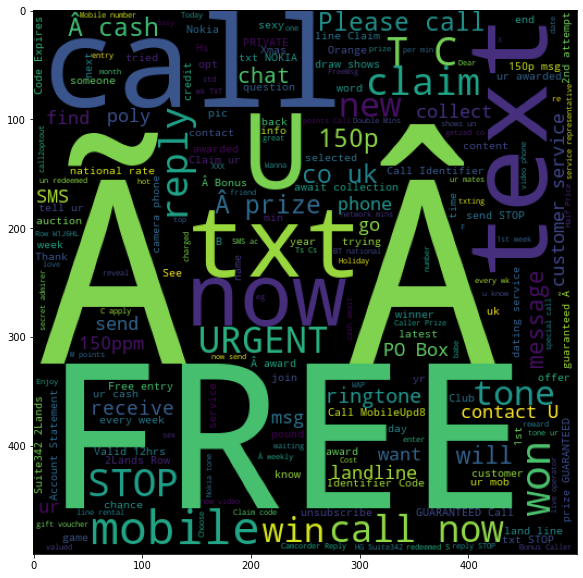

In [185]:
spam_words = ' '.join(list(df[df['v1']==1]['v2']))
spam_wc = WordCloud(width=500,height=500).generate(spam_words)
plt.figure(figsize=(10,10))
plt.imshow(spam_wc)
plt.show()

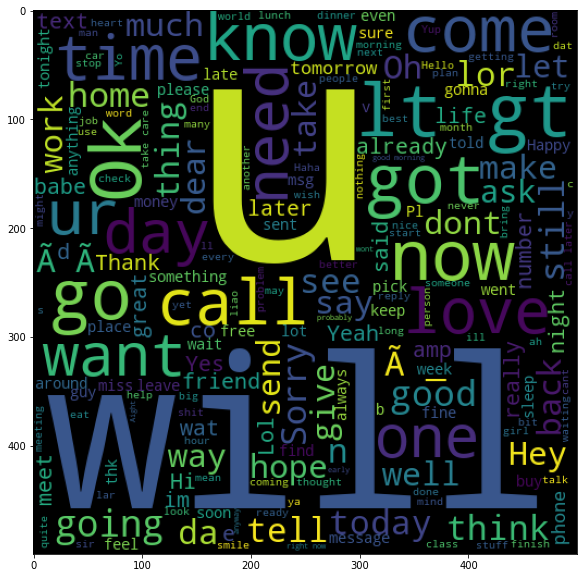

In [186]:
not_spam_words = ' '.join(list(df[df['v1']==0]['v2']))
spam_wc = WordCloud(width=500,height=500).generate(not_spam_words)
plt.figure(figsize=(10,10))
plt.imshow(spam_wc)
plt.show()

## NO UPSAMPLING OR DOWNSAMPLING, PREPROCESSING + BOW + NB + CV (GRID, RANDOM, BAYESIAN OPTIMISATION) 

In [101]:
import pandas as pd
import re
import string
import time

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn import naive_bayes
from sklearn.model_selection import GridSearchCV

In [161]:
df = pd.read_csv("../inputs/spam_data.csv",encoding='ISO-8859-1')
df = df[['v1','v2']]
df['v1'] = df['v1'].apply(lambda x: 1 if x=='spam' else 0)
df.columns = ['label','document']

In [79]:
df = df.sample(frac=1).reset_index(drop=True)
df_train = df.loc[:4500,:].reset_index(drop=True)
df_test = df.loc[4500:,:].reset_index(drop=True)

PREPROCESSING STEPS:<BR> 1) REMOVE ANYTHING THAT IS NOT A-Z AND 0-9<BR>
                     2) LOWER CASE<BR>
                     3) STOP WORDS REMOVAL<BR>
                     4) STEMMING

In [80]:
stop = list(stopwords.words('english'))
stemmer = SnowballStemmer('english')

def clean_text(sentence):
    final_string = ''
    sentence = re.sub(f'[{re.escape(string.punctuation)}]','',' '.join(word_tokenize(sentence))).lower()
    sentence = ' '.join(word_tokenize(sentence))
    for word in sentence.split():
        word = stemmer.stem(word)
        if word not in stop:
            final_string = final_string + word +' '
    return final_string.rstrip().lstrip()

In [82]:
df_train['document'] = df_train['document'].apply(lambda x: clean_text(x))

In [91]:
df_train['kfold'] = -1
kf = StratifiedKFold(n_splits=5)
for fold_,(t_,v_) in enumerate(kf.split(X=df_train,y=df_train['label'])):
    df_train.loc[v_,'kfold'] = fold_

In [97]:
for fold in range(5):
    train = df_train[df_train['kfold']!=fold].reset_index(drop=True)
    valid = df_train[df_train['kfold']==fold].reset_index(drop=True)
    
    bow = CountVectorizer(binary=True)
    bow.fit(train['document'])
    
    x_train = bow.transform(train['document'])
    y_train = train['label']
    
    x_valid = bow.transform(valid['document'])
    
    NB = naive_bayes.MultinomialNB()
    NB.fit(x_train,y_train)
    
    preds = NB.predict(x_valid)
    
    auc = metrics.roc_auc_score(valid['label'],preds)
    
    print(f'For fold = {fold}, AUC = {auc}')
    

For fold = 0, AUC = 0.9554725577452851
For fold = 1, AUC = 0.9532051282051281
For fold = 2, AUC = 0.9391025641025641
For fold = 3, AUC = 0.9528846153846153
For fold = 4, AUC = 0.9532617574979577


In [98]:
bow = CountVectorizer(binary=True)
bow.fit(df_train['document'])
x_train = bow.transform(df_train['document'])
y_train = df_train['label']

df_test['document'] = df_test['document'].apply(lambda x: clean_text(x))

x_test = bow.transform(df_test['document'])
y_test = df_test['label']

NB = naive_bayes.MultinomialNB()
NB.fit(x_train,y_train)

preds = NB.predict(x_test)

auc = metrics.roc_auc_score(y_test,preds)

print(f'AUC = {auc}')


AUC = 0.957541941003608


In [153]:
# GRID SEARCH
X = df_train['document']
X = X.apply(clean_text)
bow = CountVectorizer(binary=True)
bow.fit(X)
X = bow.transform(X)
y = df_train['label']

classifier = naive_bayes.MultinomialNB()
param_grid = {'alpha':[0.0001,0.001,0.01,0.1,1,10,100,1000]}
model = GridSearchCV(estimator = classifier, param_grid=param_grid,verbose=10,scoring='roc_auc',cv=5)
model.fit(X,y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5; 1/8] START alpha=0.0001................................................
[CV 1/5; 1/8] END .................alpha=0.0001;, score=0.977 total time=   0.0s
[CV 2/5; 1/8] START alpha=0.0001................................................
[CV 2/5; 1/8] END .................alpha=0.0001;, score=0.991 total time=   0.0s
[CV 3/5; 1/8] START alpha=0.0001................................................
[CV 3/5; 1/8] END .................alpha=0.0001;, score=0.971 total time=   0.0s
[CV 4/5; 1/8] START alpha=0.0001................................................
[CV 4/5; 1/8] END .................alpha=0.0001;, score=0.978 total time=   0.0s
[CV 5/5; 1/8] START alpha=0.0001................................................
[CV 5/5; 1/8] END .................alpha=0.0001;, score=0.974 total time=   0.0s
[CV 1/5; 2/8] START alpha=0.001.................................................
[CV 1/5; 2/8] END ..................alpha=0.001;,

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             scoring='roc_auc', verbose=10)

In [154]:
model.best_params_

{'alpha': 0.1}

In [155]:
X_test = df_test['document']
X_test = X_test.apply(clean_text)
X_test = bow.transform(X_test)
y_test = df_test['label']

NB = naive_bayes.MultinomialNB(alpha=0.1)
NB.fit(X,y)

preds = NB.predict(X_test)

print(metrics.roc_auc_score(y_test,preds))
print(metrics.precision_score(y_test,preds))

0.9588327195625488
0.9571428571428572


In [156]:
preds = NB.predict(X)

print(metrics.roc_auc_score(y,preds))
print(metrics.precision_score(y,preds))

0.9934777551787279
0.9802631578947368


In [131]:
X_test = df_test['document']
X_test = X_test.apply(clean_text)
X_test = bow.transform(X_test)
y_test = df_test['label']

train_auc = []
test_auc = []
for alpha in [0.0001,0.001,0.01,0.1,1,10,100,1000]:
    NB = naive_bayes.MultinomialNB(alpha=alpha)
    NB.fit(X,y)

    preds_test = NB.predict(X_test)
    preds_train = NB.predict(X)
    auc_test = metrics.roc_auc_score(y_test,preds_test)
    auc_train = metrics.roc_auc_score(y,preds_train)
    
    train_auc.append(auc_train)
    test_auc.append(auc_test)
    #print('ALPHA: '+ str(alpha) + ' TRAINING AUC: '+ str(round(auc_train,2))+' TEST AUC: '+ str(round(auc_test,2)))


In [135]:
alpha = [0.0001,0.001,0.01,0.1,1,10,100,1000]

In [139]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [140]:
temp_df = pd.DataFrame({'alpha':alpha,'train_auc':train_auc,'test_auc':test_auc})

<AxesSubplot:xlabel='alpha'>

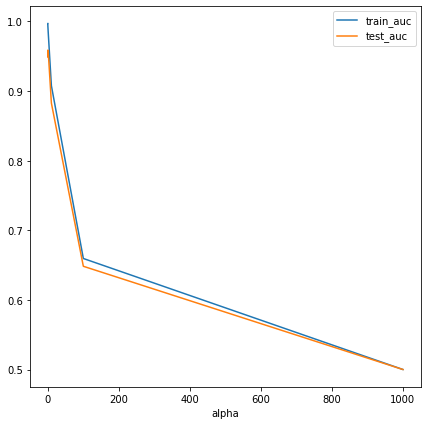

In [150]:
fig,ax = plt.subplots(figsize=(7,7))
temp_df.plot(x = 'alpha',y='train_auc',ax=ax)
temp_df.plot(x = 'alpha',y='test_auc',ax=ax)
#plt.xlim(0,1)

In [151]:
bow.vocabulary_

{'congratul': 1874,
 'ore': 4485,
 'mo': 4074,
 'owo': 4526,
 'wa': 6444,
 'enjoy': 2400,
 'wish': 6597,
 'mani': 3908,
 'happi': 3039,
 'moment': 4097,
 'fro': 2753,
 'wherev': 6555,
 'go': 2879,
 'chosen': 1741,
 'receiv': 5014,
 '350': 495,
 'award': 1174,
 'pls': 4708,
 'call': 1563,
 'claim': 1758,
 'number': 4365,
 '09066364311': 221,
 'collect': 1815,
 'select': 5304,
 'valu': 6356,
 'mobil': 4079,
 'custom': 2001,
 'want': 6471,
 'snow': 5521,
 'freez': 2731,
 'windi': 6587,
 'yes': 6778,
 'rent': 5070,
 'veri': 6376,
 'expen': 2507,
 'way': 6494,
 'save': 5247,
 'someon': 5542,
 'know': 3585,
 'ask': 1112,
 'date': 2041,
 'servic': 5327,
 'contact': 1881,
 'cant': 1600,
 'guess': 2988,
 '09058091854': 163,
 'reveal': 5112,
 'po': 4718,
 'box385': 1431,
 'm6': 3856,
 '6wu': 665,
 'nan': 4200,
 'sonathaya': 5556,
 'soladha': 5535,
 'whi': 6559,
 'boss': 1412,
 'wow': 6660,
 'never': 4253,
 'realiz': 5002,
 'embarass': 2377,
 'accomod': 845,
 'thought': 6017,
 'like': 3718,
 'sin